In [7]:
from SpatialUMAP import *
from PlottingTools import *

#### Spatial UMAP 2D Density Plots By Lineage and with PD-L1 and PD1 overlays

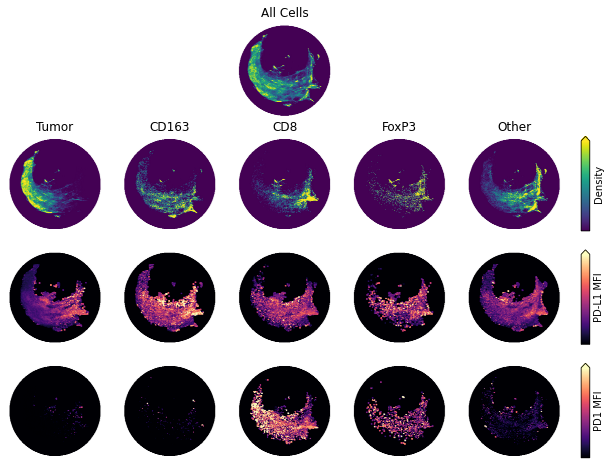

In [8]:
# load spatial_umap object
spatial_umap = pickle.load(open('data/pickles/spatial_umap.pkl', 'rb'))

# set meshgrid / bins for 2d plots based on UMAP x, y distributions
n_bins = 200
xx = np.linspace(np.min(spatial_umap.umap_test[:, 0]), np.max(spatial_umap.umap_test[:, 0]), n_bins + 1)
yy = np.linspace(np.min(spatial_umap.umap_test[:, 1]), np.max(spatial_umap.umap_test[:, 1]), n_bins + 1)
n_pad = 30

# get figure and axes
f, ax = plt.subplots(4, 6, figsize=(12, 8), facecolor='white')

# color maps
cmap_viridis = plt.get_cmap('viridis')
cmap_viridis.set_under('white')
cmap_magma = plt.get_cmap('magma')
cmap_magma.set_under('white')
cmap_bwr = plt.get_cmap('bwr')

# plot cmaps
plt_cmap(ax=ax[1, 5], cmap=cmap_viridis, extend='max', width=0.01, ylabel='Density')
plt_cmap(ax=ax[2, 5], cmap=cmap_magma, extend='max', width=0.01, ylabel='PD-L1 MFI')
plt_cmap(ax=ax[3, 5], cmap=cmap_magma, extend='max', width=0.01, ylabel='PD1 MFI')

# clear unneeded axes
[ax[_].set(visible=False) for _ in [(0, 0), (0, 1), (0, 3), (0, 4), (0, 5)]]

# plot 2d denisty in umap of all cells
plot_2d_density(spatial_umap.umap_test[:, 0], spatial_umap.umap_test[:, 1], bins=[xx, yy], n_pad=n_pad, ax=ax[0, 2], cmap=cmap_viridis)
ax[0, 2].set(title='All Cells')

# set lineages to show and in what order
lineages_plot = ['Tumor', 'CD163', 'CD8', 'FoxP3', 'Other']

# get MFI log scaled for PD-L1
w = {'PD-L1': spatial_umap.cells['PDL1_520'].values[spatial_umap.cells['umap_test']]}
w['PD-L1'] = np.log(0.1 * w['PD-L1'] + 0.1)
w['PD-L1'] -= np.min(w['PD-L1'])

# get MFI log scaled for PD1
w['PD1'] = spatial_umap.cells['PD1_650'].values[spatial_umap.cells['umap_test']]
w['PD1'] = np.log(0.1 * w['PD1'] + 0.01)
w['PD1'] -= np.min(w['PD1'])
w['PD1'] = np.maximum(w['PD1'] - 4, 0)

for i in range(len(lineages_plot)):
    # cells of lineage(s)
    idx = spatial_umap.cells['Lineage'].values[spatial_umap.cells['umap_test']] == lineages_plot[i]
    ax[1, i].cla()
    ax[1, i].set(title=lineages_plot[i])

    # plot density
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], ax=ax[1, i], cmap=cmap_viridis, vlim=.95)

    # plot PD-L1 MFI
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], w=w['PD-L1'][idx], ax=ax[2, i],
                    cmap=cmap_magma, vlim=np.array([0, np.quantile(w['PD-L1'], .975)]))
    # plot PD1 MFI
    plot_2d_density(spatial_umap.umap_test[idx, 0], spatial_umap.umap_test[idx, 1], bins=[xx, yy], w=w['PD1'][idx], ax=ax[3, i], cmap=cmap_magma,
                    vlim=np.array([0, np.quantile(w['PD1'], .975)]))


#### Spatial UMAP 2D Density Plots By Lineage and Stratified by 5 Year Survival

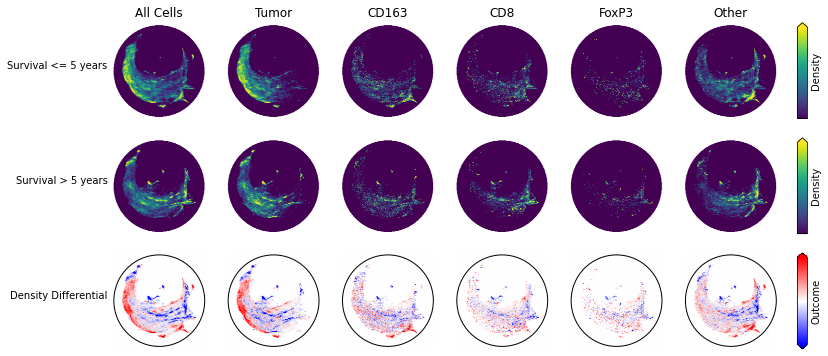

In [9]:
# get per specimen density maps

# set number of bins and get actual binning points based on whole dataset
n_bins = 200
xx = np.linspace(np.min(spatial_umap.umap_test[:, 0]), np.max(spatial_umap.umap_test[:, 0]), n_bins + 1)
yy = np.linspace(np.min(spatial_umap.umap_test[:, 1]), np.max(spatial_umap.umap_test[:, 1]), n_bins + 1)
# initialize holding nd matrix for densities
n_lineages = len(lineages_plot)
# last dim is 0:counts, 1:smoothed, density
H = np.empty([n_bins, n_bins, n_lineages + 1, len(spatial_umap.patients['Sample_number']), 2])
for i in range(len(spatial_umap.patients['Sample_number'])):
    # get cells of this specimen / patient
    idx_pts = spatial_umap.cells.loc[spatial_umap.cells['umap_test'], 'Sample_number'] == spatial_umap.patients['Sample_number'].iloc[i]
    if np.sum(idx_pts) > 0:
        # get counts for lineages
        for j in range(len(lineages_plot)):
            idx_lineage = spatial_umap.cells.loc[spatial_umap.cells['umap_test'], 'Lineage'].isin([lineages_plot[j]])
            H[:, :, j, i, 0], _, _ = np.histogram2d(spatial_umap.umap_test[idx_pts & idx_lineage, 0],
                                                    spatial_umap.umap_test[idx_pts & idx_lineage, 1], bins=[xx, yy])
        # get counts across all lineages
        H[:, :, j + 1, i, 0] = np.nansum(H[:, :, 0:(j + 1), i, 0], axis=2)

        # make smoothed density for lineages
        for j in range(len(lineages_plot)):
            if np.sum(H[:, :, j, i, 0]) > 0:
                H[:, :, j, i, 1] = ndi.gaussian_filter(H[:, :, j, i, 0] / np.sum(H[:, :, j, i, 0]), sigma=0.5)
            else:
                H[:, :, j, i, 1] = np.nan
        # make smoothed density for all lineages
        if np.sum(H[:, :, j + 1, i, 0]) > 0:
            H[:, :, j + 1, i, 1] = ndi.gaussian_filter(H[:, :, j + 1, i, 0] / np.sum(H[:, :, j + 1, i, 0]), sigma=0.5)
        else:
            H[:, :, j + 1, i, 1] = np.nan
    else:
        H[:, :, :, i, :] = np.nan

# specimens with density data across all lineages
idx_d = ~np.all(np.all(np.all(np.isnan(H[..., 1]), axis=0), axis=0), axis=0)

idx_A = (spatial_umap.patients['Death_5Y'] == 1) & idx_d
idx_B = (spatial_umap.patients['Death_5Y'] == 0) & idx_d

f, ax = plt.subplots(nrows=3, ncols=7, figsize=(14, 6), facecolor='white')

plt_cmap(ax=ax[0, 6], cmap=cmap_viridis, extend='max', width=0.01, ylabel='Density')
plt_cmap(ax=ax[1, 6], cmap=cmap_viridis, extend='max', width=0.01, ylabel='Density')
plt_cmap(ax=ax[2, 6], cmap=plt.get_cmap('bwr'), extend='both', width=0.01, ylabel='Outcome')

d_idx_A = np.nanmean(H[:, :, -1, idx_A, 1], axis=-1).T
plot_2d_density(d_idx_A, bins=[xx, yy], n_pad=30, ax=ax[0, 0], circle_type='bg', cmap=cmap_viridis)
ax[0, 0].set(title='All Cells')
ax[0, 0].set_ylabel('Survival <= 5 years', rotation='horizontal', ha='right')
d_idx_B = np.nanmean(H[:, :, -1, idx_B, 1], axis=-1).T
plot_2d_density(d_idx_B, bins=[xx, yy], n_pad=30, ax=ax[1, 0], circle_type='bg', cmap=cmap_viridis)
ax[1, 0].set_ylabel('Survival > 5 years', rotation='horizontal', ha='right')
d_diff = d_idx_A - d_idx_B
plot_2d_density(d_diff, bins=[xx, yy], n_pad=30, ax=ax[2, 0], circle_type='arch', cmap=cmap_bwr)
ax[2, 0].set_ylabel('Density Differential', rotation='horizontal', ha='right')

for i in range(len(lineages_plot)):
    d_idx_A = np.nanmean(H[:, :, i, idx_A, 1], axis=-1).T
    plot_2d_density(d_idx_A, bins=[xx, yy], n_pad=30, ax=ax[0, i + 1], circle_type='bg', cmap=cmap_viridis)
    ax[0, i + 1].set(title=lineages_plot[i])
    d_idx_B = np.nanmean(H[:, :, i, idx_B, 1], axis=-1).T
    plot_2d_density(d_idx_B, bins=[xx, yy], n_pad=30, ax=ax[1, i + 1], circle_type='bg', cmap=cmap_viridis)
    d_diff = d_idx_A - d_idx_B
    plot_2d_density(d_diff, bins=[xx, yy], n_pad=30, ax=ax[2, i + 1], circle_type='arch', cmap=cmap_bwr)

